In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

def customColorMap(n, color_map):
#     helper fuction takes in two parameters, n and color_map, and returns a list of colors. 
#     n is an integer representing the number of colors to be generated. 
#     color_map is a string representing the name of the color map to be used. 
#     The function uses the matplotlib library to generate a list of colors based on the color map provided. 
#     The colors are scaled according to the range of values from 0 to n. 
    data = [i for i in range(0, n)]
    denominator = max(data) - min(data)
    colors = []
    cmap = plt.get_cmap(color_map)
    scaled_data = [(datum-min(data))/denominator for datum in data][1:-1]

    scaled_data.reverse()
    for decimal in scaled_data:
        colors.append(cmap(decimal))
    return colors

In [2]:
# retrieve data from CMS open data
# https://data.cms.gov/provider-summary-by-type-of-service/medicare-part-d-prescribers/medicare-part-d-prescribers-by-geography-and-drug/api-docs
uuid_by_year = {2020 : '83891e77-99cf-4865-b60a-97703b916e09',
                2019 : '73a6335e-f16f-4c81-a84b-6b5a986e2bf8',
                2018 : 'b083c9b6-b841-4676-8d0a-fb03ee1431a1',
                2017 : '7863e41c-3f6f-4889-93a8-be65e9f3d073',
                2016 : 'c5b3c840-5eb2-4e4c-ac35-c30995dcb051',
                2015 : '73748d0b-2acb-420a-ac66-27d8e238fdc8',
                2014 : '63099eb4-6c9e-4fec-8c9e-b6b132f1b7f4',
                2013 : '9aec2a70-4ef2-438a-bc35-1747fe2492c9'}

df_lst = []
for i in range(2013, 2020 + 1):
    url = ''.join('''https://data.cms.gov/data-api/v1/dataset/{}/data?
        filter[Prscrbr_Geo_Lvl]=National
        &offset=0&size=5000
    '''.split()).format(uuid_by_year[i])
#     print(url)
    df = pd.DataFrame(requests.get(url).json())
    df['Year'] = i 

    df_lst.append(df)


In [3]:
# assemble downloaded dataframes into a single dataframe and perform some cleaning
# data dictionary: https://data.cms.gov/resources/medicare-part-d-prescribers-by-geography-and-drug-data-dictionary
df = pd.concat(df_lst)
df[['Tot_Prscrbrs', 'Tot_Clms', 'Tot_30day_Fills', 'Tot_Drug_Cst']] = df[['Tot_Prscrbrs', 'Tot_Clms', 'Tot_30day_Fills', 'Tot_Drug_Cst']].replace({'\$': '', ',': ''}, regex=True).replace('', np.nan).astype('float')
df['Tot_Benes'] = df['Tot_Benes'].replace({'\$': '', ',': ''}, regex=True).replace('', np.nan).astype('float')

# reshape the data to index by year and brand name
df_pivot = df.pivot_table(index=['Year', 'Brnd_Name'], 
               values=['Tot_Drug_Cst', ], 
               aggfunc='sum').sort_values(by=['Year','Tot_Drug_Cst'], ascending=False)

<ipython-input-4-a78b7fe1e333>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(labels=x, rotation = 10, fontsize=14)


Text(0.5, 0.91, 'Total Drug Cost paid by Medicare by Brand Name per year\n2020 - 2016')

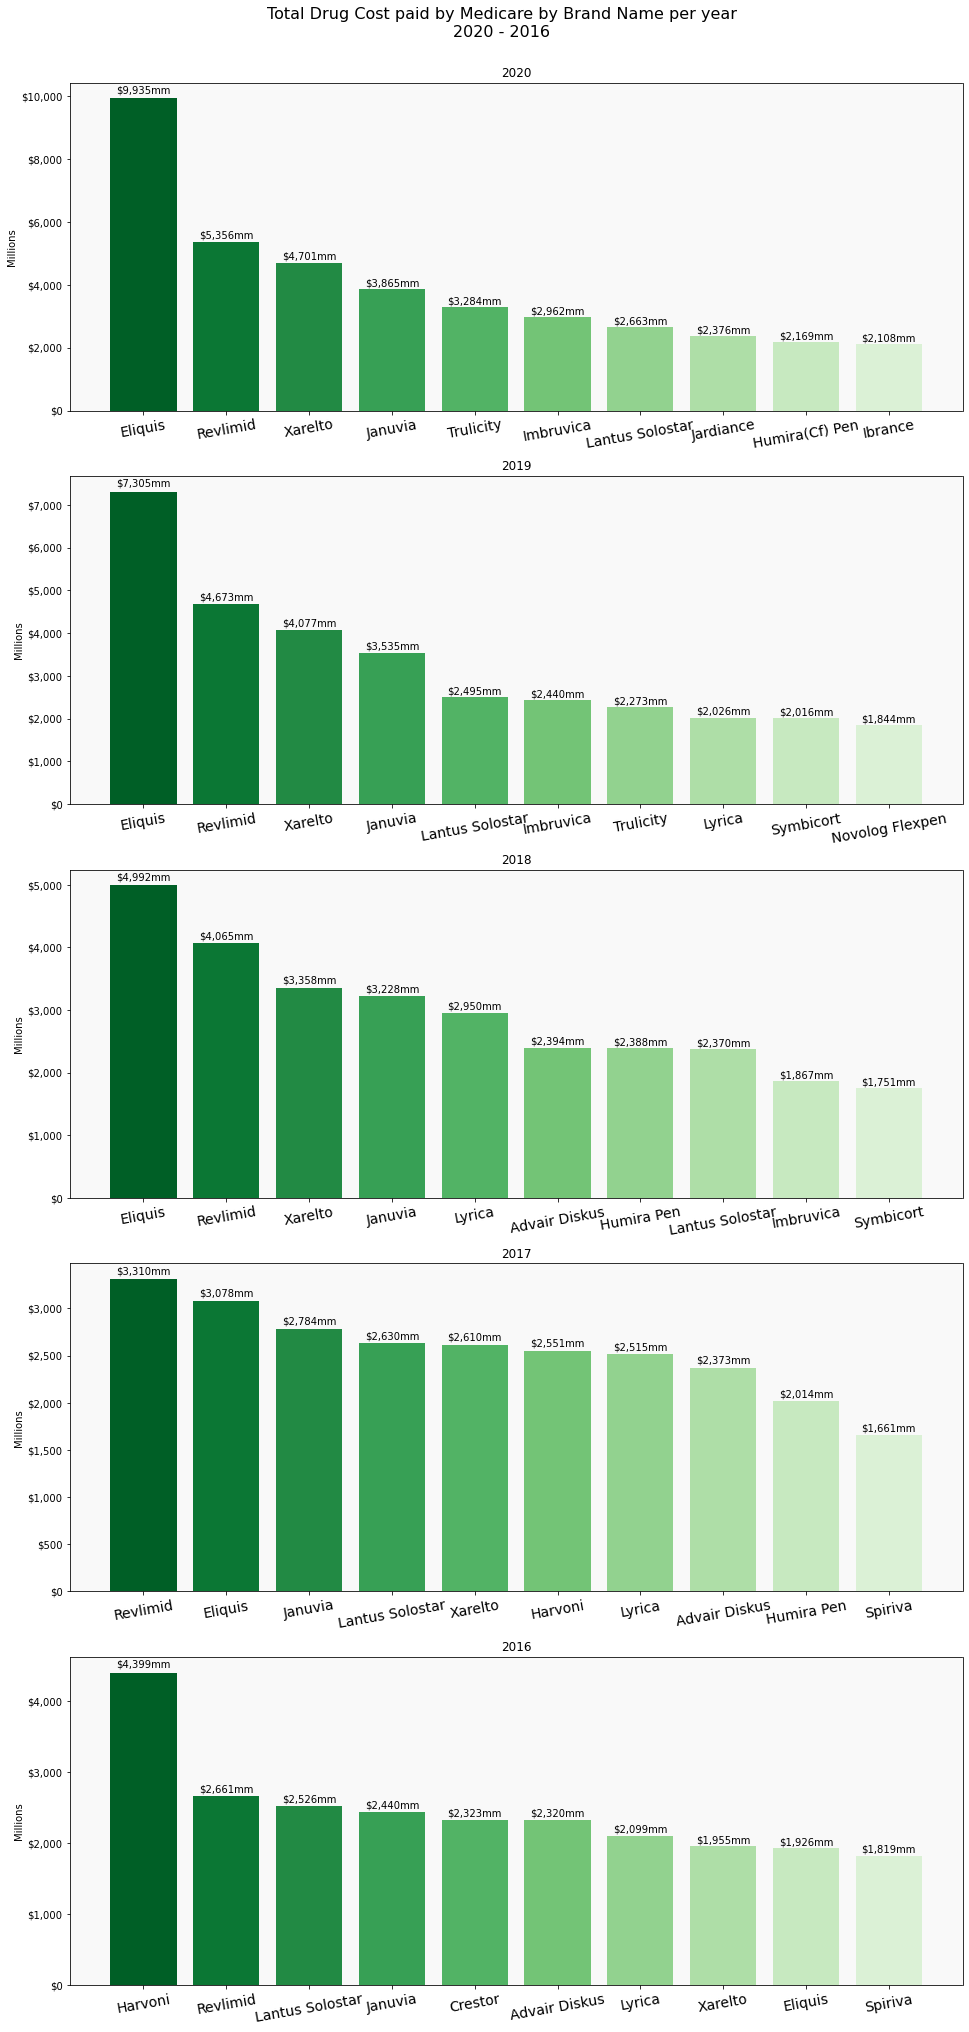

In [4]:
n = 5 # number of years to print
fig, axs = plt.subplots(n, figsize=(16,n*7))
for i in range(n):
    y = [x[0] / 1_000_000 for x in df_pivot.loc[2020-i][:10].values]
    x = df_pivot.loc[2020-i][:10].index
    axs[i].set_facecolor('#f9f9f9')
    rects = axs[i].bar(x, y, 
                       color=customColorMap(13, 'Greens'))

    for j in range(len(x)):
        axs[i].text(x = j, y = y[j] * 1.01,
                    s='${:,.0f}mm'.format(y[j]), 
                    ha="center", va='bottom')

    axs[i].set_title('{}'.format(2020-i))
    axs[i].yaxis.set_major_formatter('${x:,.0f}')
    axs[i].set_ylabel('Millions')
    axs[i].set_xticklabels(labels=x, rotation = 10, fontsize=14)
    
fig.suptitle('Total Drug Cost paid by Medicare by Brand Name per year\n{} - {}'.format(df_pivot.index[0][0], df_pivot.index[0][0]-n+1),
            fontsize=16, y = .91)
# fig.set_facecolor('#f9f9f9')
# fig.tight_layout()

Text(0.5, 0.98, 'Total Drug Cost paid by Medicare by Brand Name\nTotal 2020 - 2016')

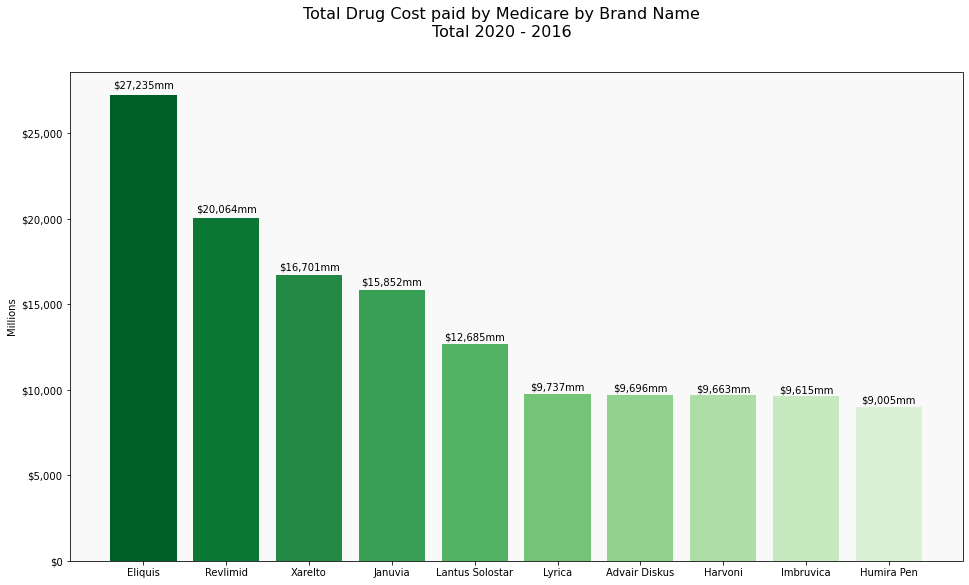

In [5]:
# sum of each drug from 2016-2020 and list top ten
x = df[df['Year'] >= 2016].groupby('Brnd_Name')['Tot_Drug_Cst'].sum().sort_values(ascending=False)[:10].index.tolist()
y = df[df['Year'] >= 2016].groupby('Brnd_Name')['Tot_Drug_Cst'].sum().sort_values(ascending=False)[:10].values.tolist()
y = [x/1_000_000 for x in y] # scales to the million

fig, ax = plt.subplots(figsize=(16,9))
ax.set_facecolor('#f9f9f9')
ax.bar(x,y,
       color=customColorMap(13, 'Greens'))

for j in range(len(x)):
    ax.text(x = j, y = y[j] * 1.01,
                s='${:,.0f}mm'.format(y[j]), 
                ha="center", va='bottom')
ax.yaxis.set_major_formatter('${x:,.0f}')
ax.set_ylabel('Millions')
fig.suptitle('Total Drug Cost paid by Medicare by Brand Name\nTotal {} - {}'.format(df_pivot.index[0][0], df_pivot.index[0][0]-n+1),
            fontsize=16, )